In [2]:
# -*- coding: utf-8 -*-

"""所有跨文件的全局变量由本模块计算并赋值

其他模块需要使用本模块全局变量时，在模块开头导入本模块即可
例子：
    from setting import *...

"""

import os
import sys
import re
from pathlib import Path


# 在pycharm的用户环境变量配置好科大讯飞的APP_ID和secretkey
LFASR_APP_ID = os.getenv("LFASR_APP_ID")
LFASR_SECRETKEY = os.getenv("LFASR_SECRETKEY")

# 获取当前工作目录的绝对路径
current_directory = Path.cwd()
# 获取根目录（上两级）
root_directory = current_directory.parents[0]
# 将根目录添加到系统路径中
sys.path.append(str(root_directory))
ROOT = Path(os.path.relpath(root_directory, Path.cwd()))  # relative

# data
DATA_DIR = ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw_data"
RESULT_DATA_DIR = DATA_DIR / "result_data"
FREQ_CSV = "调号音符频率表.csv"
SONGNAME_CSV = "文件歌曲表.csv"
SCORE_CSV = "文件评分表.csv"
RESULT_CSV = "模型结果表.csv"
EVALUATE_CSV = "评估结果表.csv"
INDEX_CSV = "指标结果表.csv"

# eigen_json
EIGEN_DIR = ROOT / "eigen_json"

# audio
UPLOAD_FILE_DIR = ROOT / "audio"

# resultJson
DOWNLOAD_DIR = ROOT / "resultJson"

# lyrics
LYRICS_DIR = ROOT / "lyrics"

# resultAudio
AUDIO_DIR = ROOT / "resultAudio"

# json结果的名字后缀
OUTPUT_JSON_NAME = "orderResult.json"

# 预处理后的audio的后缀
OUTPUT_AUDIO_NAME = "seg.wav"

# 测试脚手架
TEST_DIR = ROOT / "test_space"
TEST_AUDIO_DIR = TEST_DIR / "audio"
TEST_EIGEN_DIR = TEST_DIR / "eigen_json"
TEST_RESULT_DIR = TEST_DIR / "orderResult_example"
TEST_AUDIO_EIGEN_DIR = TEST_DIR / "audio_eigen_test"
TEST_DATA_DIR = TEST_DIR / "data"
TEST_RAWDATA_DIR = TEST_DATA_DIR / "raw_data"
TEST_RESULTDATA_DIR = TEST_DATA_DIR / "result_data"


In [25]:
from pathlib import Path
from funasr import AutoModel
import librosa
import json
import copy
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from dtw import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mpt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [31]:
def z_score_normalization(data: list):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

In [5]:
def funasr_run(
    model: str = "iic/speech_paraformer-large-vad-punc_asr_nat-zh-cn-16k-common-vocab8404-pytorch",
    vad_model: str = "fsmn-vad",
    punc_model: str = "ct-punc-c",
    input_audio_dir: Path = UPLOAD_FILE_DIR,
    input_audio_dataset: str = None,
    input_audio_name: str = None,
    input_parsed_audio: np.ndarray = None,
    input_mode: str = "file",
    download_json_dir: Path = DOWNLOAD_DIR,
) -> dict:
    """使用funasr进行ASR（语音识别）,输出识别文字以及每个字的时间戳

    参数：
        model(str):
            选用的模型，默认为"iic/speech_paraformer-large-vad-punc_asr_nat-zh-cn-16k-common-vocab8404-pytorch"，如何选择模型详见达摩院Paraformer large
        vad_model(str):
            语音活动检测选用的模型，默认为fsmn-vad
        punc_model(str):
            标点检测选用的模型，默认为ct-punc-c
        input_audio_dir(Path):
            待识别音频所处的爷目录，默认为UPLOAD_FILE_DIR
        input_audio_dataset(str):
            待识别音频所处的数据集名称
        input_audio_name(str):
            音频文件名（带后缀）
        input_parsed_audio(np.ndarray):
            已解析的audio信号序列
        input_mode(str):
            输入的形式，包括：
                file：输入音频文件
                parsed：输入已解析的audio信号序列
        download_json_dir(Path):
            输出结果保存为json的爷目录，默认为DOWNLOAD_DIR

    返回：
        rs_dict(dict):
            只有一个元素的列表，元素为字典，结构如下：
                key（str）:
                    随机种子
                text（str）:
                    识别文本
                timestamp(list):
                    识别文本每个字的时间戳
    """
    if input_audio_name is not None:
        path_str = str(input_audio_dir / input_audio_dataset / input_audio_name)
    download_dir = download_json_dir / input_audio_dataset
    if not download_dir.exists():
        download_dir.mkdir(parents=True)

    real_audio_name = re.sub(r'\..*', '', input_audio_name)
    json_name = real_audio_name + '.json'
    download_path = download_dir / json_name

    if not download_path.exists():
        model = AutoModel(
            model=model,
            model_revision="v2.0.4",
            vad_model=vad_model,
            vad_model_revision="v2.0.4",
            punc_model=punc_model,
            punc_model_revision="v2.0.4",
        )
        if input_mode == "file":
            rs_list = model.generate(input=path_str, batch_size_s=300)
        elif input_mode == "parsed":
            rs_list = model.generate(input=input_parsed_audio, batch_size_s=300)

        rs_dict = rs_list[0]

        with open(download_path, "w", encoding="gbk") as json_file:
            json.dump(rs_dict, json_file, indent=2, ensure_ascii=False)
    else:
        with open(download_path, "r", encoding="gbk") as file:
            rs_dict = json.load(file)

    return rs_dict

In [6]:
def getWordInfoList(funasr_dict: dict) -> dict:
    """提供类似funasr_run输出结果的列表，生成一个eigen_list字典

    详细生成结果例子见ROOT / "orderResult_example"   / "getWordInfoList_result.json"

    参数：
        funasr_dict(dict)：
            funasr_run输出结果形式的列表

    返回：
        eigen_dict(dict)：
            结构如下：
            eigen_list(list[dict])
                    word(str):字
                    eigen(dict)
                        start_time(float)
                        end_time(float)
    """
    text = funasr_dict["text"]
    time = funasr_dict["timestamp"]
    text = re.sub(r"[^\u4e00-\u9fa5\d]+", "", text)

    eigen_dict = {"eigen_list": []}

    for i in range(len(text)):
        eigen_dict_item = {"word": "", "eigen": {}}
        eigen = eigen_dict_item["eigen"]

        eigen_dict_item["word"] = text[i]

        eigen["start_time"] = round(time[i][0] / 1000, 3)
        # 检验与下一个字之间的时间差，<2秒则意味着中间无明显间隔
        if (i < len(text) - 1) and (time[i + 1][0] - time[i][1] <= 2000):
            eigen["end_time"] = round(time[i + 1][0] / 1000, 3)
        else:
            eigen["end_time"] = round(time[i][1] / 1000, 4)

        eigen_dict["eigen_list"].append(eigen_dict_item)

    return eigen_dict

In [7]:
def calAudioFreq(
    reduced_noise: np.ndarray, sr: int, fmax: float = 2093.0, fmin: float = 65.0
) -> tuple:
    """使用Pyin算法来估计各时刻的基音频率，生成一个元组，包括基频列表和基频对应的times列表.

    reduced_noise:
        noiseReduce的返回结果。
    sr：
        noiseReduce的返回的采样率。
    fmax：
        估计的最大频率，默认为2093.0。
    fmin:
        估计的最小频率，默认为65.0。

    返回：
        Freq_list：
            基频列表。
        times_list：
            各基频对应的times的列表。
    """
    # Freq_list 以赫兹为单位的基频时间序列。voiced_flag 包含指示帧是否有声的布尔标志的时间序列；voiced_probs 包含帧有声概率的时间序列。
    Freq_list, voiced_flag, voiced_probs = librosa.pyin(
        y=reduced_noise, sr=sr, fmin=fmin, fmax=fmax
    )

    times_list = librosa.times_like(Freq_list)
    Freq_list = Freq_list.tolist()
    times_list = times_list.tolist()
    return Freq_list, times_list

In [8]:
# -*- coding: utf-8 -*-

"""模块功能描述

简谱特征提取模块，通过定义extractJson、calNoteTime、calNoteFreq方法，分别将JSON简谱文件识别并提取为字典格式后，通过曲子的BPM和拍号
计算出每个歌词的音长，最后算出每个切割后的词所对应的频率。

经典的使用示例：

data = extractJson()
eigen_dict_t = calNoteTime(eigen_dict = data)
eigen_dict_rs = calNoteFreq()
"""

import json
import pandas as pd


def extractJson(json_dir: Path = EIGEN_DIR, json_name: str = None):
    """提取json文件，将其输出为字典格式。

    通过指定的路径，将JSON文件的内容识别出来，并转为dict格式输出。

    参数：
        json_dir：
            根目录，eg：EIGEN_DIR = ROOT / "eigen_json"。
        json_name：
            去掉尾缀后的文件名，eg：self.json_name = "中华人民共和国国歌测试"。

    返回：
        eigen_dict为从JSON文件中提出的结果。

    """

    json_name = json_name + ".json"
    json_filename = os.path.join(json_dir, json_name)
    '''使用with方法，文件加载后赋值给data后会自动关闭，无需写代码手动关闭'''
    with open(json_filename, "r", encoding="gbk") as f:
        data = json.load(f)
    eigen_dict = data
    return eigen_dict


def calNoteTime(eigen_dict: dict) -> dict:
    """传入extractJson的输出结果，根据bpm和time_signature来计算所有note对应的音长，单位为秒

    音长的计算公式为：（60÷BPM）×（拍号的分母/4）× 每个词的拍数

    参数：eigen_dict：
        将extractJson读取的JSON文件结果传进来。

    返回：
        eigen_dict_t:
            原始JSON中time键所对应的value值替换为音长
    """
    bpm = eigen_dict["bpm"]  # 存储简谱中的BPM值
    note = eigen_dict["time_signature"][1]

    """遍历文件eigen_dict下的eigen_list键中所嵌套的dict值，将子键值对eigen中将time提取出来，通过公式计算后的音长替换掉原来的时间"""
    eigen_list = eigen_dict["eigen_list"]
    for eigen in eigen_list:
        time = eigen["eigen"]["time"]
        word_duration = [60 / bpm * note / 4 * t for t in time]
        eigen["eigen"]["time"] = word_duration
    eigen_dict_t = eigen_dict

    return eigen_dict_t


def calNoteFreq(
    eigen_dict_t: dict, data_dir: Path = RAW_DATA_DIR, data_name: str = FREQ_CSV, note_sig: str = None
) -> dict:
    """传入calNoteTime的输出结果,计算每个词的频率。

    根据raw_data中的调号音符频率表以及给定的调号，计算调号对应的简谱里所有音符的频率，单位为HZ，计算出简谱中eigen_list所有word对应的频率值，
    并将计算出来的频率值替换掉以前的JSON文件中的note值。

    参数：
        eigen_dict_t：
            calNoteTime处理后的JSON文件。
        data_dir：
            调号音符频率表所在目录的绝对路径,默认为RAW_DATA_DIR。
        data_name：
            调号音符频率表的名称，默认为FREQ_CSV。
        note_sig：
            调号，乐理中的概念。取值范围为调号频率表的音名1 列和音名2列取值范围。

    返回：
        eigen_dict_rs:
            将calNoteTime处理后JSON中note键所对应的value值替换为频率

    """

    csv_filename = os.path.join(data_dir, data_name)  # 拼接csv文件所在的路径
    df = pd.read_csv(csv_filename, encoding="gbk")  # 读取音符频率表
    # matched_rows为子表，根据传入的调号note_sig找出相应音名的子表
    matched_rows = df[(df["音名1"] == note_sig) | (df["音名2"] == note_sig)]

    # 在传进的JSON文件中，定位到多层键值对下的eigen_list，并将对应的键值对赋值给eigen_list
    eigen_list = eigen_dict_t["eigen_list"]

    notes = []  # 用来存放JSON文件中的note键对应的value值
    """遍历eigen_list中所有的eigen下的子键值对，将note所对应的值存储到notes中，eg：notes=[['-5'], ['1'], ['1'], ['1'], ['+1'], ['-1', '--6']]"""
    for eigen in eigen_list:
        note = eigen["eigen"]["note"]
        notes.append(note)

    """第一层for循环进入到所有的子列表中，eg：['-5']，第二层for循环进入到该子列表中的数字，eg：-5，第三层for循环识别统计有多少个'+'，'-'符号"""
    for sublist in notes:
        for i in range(len(sublist)):
            item = sublist[i]
            negative_count = 0  # 用于统计'-'的个数
            positive_count = 0  # 用于统计'+'的个数
            numbers = []  # 用于存储第三层循环中除去符号后的数字，eg：'-5'——>5

            for char in item:
                if char == "-":
                    negative_count += char.count("-")
                elif char == "+":
                    positive_count += char.count("+")

            number = char.replace("-", "").replace("+", "")
            numbers.append(number)
            # 找出音名所对应的频率值
            matched_freq = matched_rows[matched_rows["唱名"] == number]["频率"].values
            """如果找到的频率值长度大于0，则取出，否则赋值为None"""
            if len(matched_freq) > 0:
                matched_freq = matched_freq[0]
            else:
                matched_freq = None
            """如果第二层循环取出的数字有'+'符号是，表示频率值需变为2的指数倍，eg：'++3'表示为，频率值为4倍（2的平方=4）音名3的频率；
            取出的数字有'-'号表示频率值变为1/2的指数倍；如果没有'+'，'-'符号，则直接取出频率值"""
            if negative_count > 0 and positive_count == 0:
                matched_freq = matched_freq * 0.5**negative_count
            elif positive_count > 0 and negative_count == 0:
                matched_freq = matched_freq * 2**positive_count
            else:
                matched_freq = matched_freq
            """将计算出来的音符的频率值替换掉原JSON文件中的note的值，将替换放在第二层是因为遇到特殊子表['+1', '--6']时，可以不破坏子列表的结构也可以将计算后频率值放回"""
            sublist[i] = matched_freq

    eigen_dict_rs = eigen_dict_t

    return eigen_dict_rs


In [9]:
def getSheetMusicFeatDict(json_name: str = "国歌"):
    key_sig_list = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]

    notation_feat_dict = {}
    for i in range(len(key_sig_list)):
        eigen_dict = extractJson(json_name=json_name)
        eigen_dict_t = calNoteTime(eigen_dict)
        eigen_dict_rs = calNoteFreq(eigen_dict_t, note_sig=key_sig_list[i])
        
        # 进行深拷贝
        eigen_dict_rs_copy = copy.deepcopy(eigen_dict_rs)

        notation_feat_dict[key_sig_list[i]] = eigen_dict_rs

        new_key_name = key_sig_list[i] + "/2"
        # 遍历每个 eigen 字典，将 note 键对应的值除以 2
        for item in eigen_dict_rs_copy['eigen_list']:
            item['eigen']['note'] = [x / 2 for x in item['eigen']['note']]
        notation_feat_dict[new_key_name] = eigen_dict_rs_copy
            
    return notation_feat_dict

In [10]:
def getPerWordFeat(eigen_dict: dict, freq_list: list, times_list: list, crop_percent: float=0.2) -> dict:
    """根据adjustWordTime和calAudioFreq的结果来计算每个字的基频f0。

    参数：
        eigen_dict(dict)：
            adjustWordTime的结果
        freq_list(list)：
            calAudioFreq的结果
        times_list(list)：
            calAudioFreq的结果
        crop_percent(float)：
            每个字的基频序列的裁剪比例，默认为0.2

    返回：
        rs_dict(dict)，结构如下：
            eigen_list(list[dict])
                word(str)
                eigen(dict)
                    start_time(float)
                    end_time(float)
                    times(float)
                    freq(float)
    """
    eigen_list = eigen_dict["eigen_list"]
    for i in range(len(eigen_list)):
        item = eigen_list[i]["eigen"]
        times = item["end_time"]-item["start_time"]
        if times > 0.1:
            seg_start_time = item["start_time"]+times*crop_percent
            seg_end_time = item["end_time"]-times*crop_percent

        indices = [
            index for index, time in enumerate(times_list) if seg_start_time <= time <= seg_end_time
        ]
        freq_seq = [freq_list[index] for index in indices if not np.isnan(freq_list[index])]
        item["freq"] = round(np.median(freq_seq), 3)
        item["times"] = round(times, 3)

    return eigen_dict

In [21]:
def cal_dtw_freq_and_tempo(notation_feat_dict: dict, pwf_dict: dict):
    # 提取pwf_dict 字典里的所有times和freq，分别按顺序得到times_list和freq_list
    freq_list = [item["eigen"]["freq"] for item in pwf_dict["eigen_list"]]
    times_list = [item["eigen"]["times"] for item in pwf_dict["eigen_list"]]

    dtw_rs_dict = {}

    # 提取notation_feat_dict 字典里的所有times和note，分别按顺序得到orignal_freq_list和orignal_times_list
    for key in notation_feat_dict.keys():
        orignal_freq_list = [
            np.average(item["eigen"]["note"], weights=item["eigen"]["time"])
            for item in notation_feat_dict[key]["eigen_list"]
        ]
        freq_dtw_rs = dtw(freq_list, orignal_freq_list, dist_method='euclidean')

        orignal_times_list = [
            np.sum(item["eigen"]["time"])
            for item in notation_feat_dict[key]["eigen_list"]
        ]
        tempo_dtw_rs = dtw(times_list, orignal_times_list, dist_method='euclidean')

        dtw_rs_dict[key] = {}
        dtw_rs_dict[key]["freq_dist_normalized"] = freq_dtw_rs.normalizedDistance
        dtw_rs_dict[key]["tempo_dist_normalized"] = tempo_dtw_rs.normalizedDistance

    return dtw_rs_dict

In [29]:
def cal_dtw_freq_and_tempo(notation_feat_dict: dict, pwf_dict: dict):
    # 提取pwf_dict 字典里的所有times和freq，分别按顺序得到times_list和freq_list
    freq_list = [item["eigen"]["freq"] for item in pwf_dict["eigen_list"]]
    times_list = [item["eigen"]["times"] for item in pwf_dict["eigen_list"]]
    z_freq_list = z_score_normalization(freq_list)
    z_times_list = z_score_normalization(times_list)

    dtw_rs_dict = {}

    # 提取notation_feat_dict 字典里的所有times和note，分别按顺序得到orignal_freq_list和orignal_times_list
    for key in notation_feat_dict.keys():
        orignal_freq_list = [
            np.average(item["eigen"]["note"], weights=item["eigen"]["time"])
            for item in notation_feat_dict[key]["eigen_list"]
        ]
        z_orignal_freq_list = z_score_normalization(orignal_freq_list)
        freq_dtw_rs = dtw(z_freq_list, z_orignal_freq_list, dist_method='euclidean')

        orignal_times_list = [
            np.sum(item["eigen"]["time"])
            for item in notation_feat_dict[key]["eigen_list"]
        ]
        z_orignal_times_list = z_score_normalization(orignal_times_list)
        tempo_dtw_rs = dtw(z_times_list, z_orignal_times_list, dist_method='euclidean')

        dtw_rs_dict[key] = {}
        # dtw_rs_dict[key]["freq_dist_normalized"] = freq_dtw_rs.normalizedDistance
        # dtw_rs_dict[key]["tempo_dist_normalized"] = tempo_dtw_rs.normalizedDistance
        dtw_rs_dict[key]["freq_dist_normalized"] = freq_dtw_rs.distance
        dtw_rs_dict[key]["tempo_dist_normalized"] = tempo_dtw_rs.distance

    return dtw_rs_dict

In [11]:
# 测试funasr_run
rs_dict = funasr_run(input_audio_dataset = "qilai", input_audio_name="cst.mp3")
rs_dict

{'key': 'rand_key_2yW4Acq9GFz6Y',
 'text': '起来不愿做努力的人们，把我们的血肉筑成我们新的长城。中华民族到了最危险的时候，每一个人被迫着发出最后的吼声起来起来起来，我们万众一心冒着敌人的炮火前进，冒着敌人的炮火前进，前进，前进进。',
 'timestamp': [[780, 1020],
  [1180, 1420],
  [2260, 2500],
  [2620, 2860],
  [3140, 3380],
  [3420, 3660],
  [3680, 3860],
  [3860, 4060],
  [4060, 4300],
  [4580, 4820],
  [5720, 5960],
  [6100, 6340],
  [6380, 6600],
  [6600, 6800],
  [6800, 7040],
  [7440, 7680],
  [8160, 8400],
  [8640, 8880],
  [8920, 9160],
  [9280, 9520],
  [9620, 9860],
  [10000, 10240],
  [10280, 10520],
  [10840, 11405],
  [12380, 12620],
  [12960, 13200],
  [13740, 13980],
  [14340, 14580],
  [15100, 15340],
  [15420, 15660],
  [16140, 16380],
  [16520, 16760],
  [16860, 17020],
  [17020, 17260],
  [17300, 17540],
  [17920, 18160],
  [19360, 19600],
  [19660, 19800],
  [19800, 20020],
  [20020, 20259],
  [20360, 20600],
  [20600, 20840],
  [21120, 21280],
  [21280, 21520],
  [21560, 21800],
  [21940, 22160],
  [22160, 22400],
  [22400, 22620],
  [22620, 22860],
  [23160

In [12]:
# 测试getWordInfoList
eigen_dict = getWordInfoList(funasr_dict=rs_dict)
eigen_dict

{'eigen_list': [{'word': '起', 'eigen': {'start_time': 0.78, 'end_time': 1.18}},
  {'word': '来', 'eigen': {'start_time': 1.18, 'end_time': 2.26}},
  {'word': '不', 'eigen': {'start_time': 2.26, 'end_time': 2.62}},
  {'word': '愿', 'eigen': {'start_time': 2.62, 'end_time': 3.14}},
  {'word': '做', 'eigen': {'start_time': 3.14, 'end_time': 3.42}},
  {'word': '努', 'eigen': {'start_time': 3.42, 'end_time': 3.68}},
  {'word': '力', 'eigen': {'start_time': 3.68, 'end_time': 3.86}},
  {'word': '的', 'eigen': {'start_time': 3.86, 'end_time': 4.06}},
  {'word': '人', 'eigen': {'start_time': 4.06, 'end_time': 4.58}},
  {'word': '们', 'eigen': {'start_time': 4.58, 'end_time': 5.72}},
  {'word': '把', 'eigen': {'start_time': 5.72, 'end_time': 6.1}},
  {'word': '我', 'eigen': {'start_time': 6.1, 'end_time': 6.38}},
  {'word': '们', 'eigen': {'start_time': 6.38, 'end_time': 6.6}},
  {'word': '的', 'eigen': {'start_time': 6.6, 'end_time': 6.8}},
  {'word': '血', 'eigen': {'start_time': 6.8, 'end_time': 7.44}},
  

In [13]:
# 根据start_time 和end_time切割音频输出并画CQT色度图，检查音长边缘误差问题

# audio = AudioSegment.from_file(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\audio\qilai\cst.mp3")
# eigen_list = eigen_dict["eigen_list"]
# for i in range(len(eigen_list)):
#     output_wav = f'{i}{eigen_list[i]["word"]}.wav'
#     output_png = f'{i}{eigen_list[i]["word"]}.png'
#     segment = audio[eigen_list[i]["eigen"]["start_time"] : eigen_list[i]["eigen"]["end_time"]]
#     segment.export(ROOT / "jupyter" / "cst_new" / output_wav, format="wav")
#     seg_y, sr = librosa.load(ROOT / "jupyter" / "cst_new" / output_wav)

#     chroma = librosa.feature.chroma_cqt(y=seg_y, sr=sr)
#     bounds = librosa.segment.agglomerative(chroma, 2)
#     bound_times = librosa.frames_to_time(bounds, sr=sr)

#     fig, ax = plt.subplots()
#     trans = mpt.blended_transform_factory(
#                 ax.transData, ax.transAxes)
#     librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
#     ax.vlines(bound_times, 0, 1, color='linen', linestyle='--',
#               linewidth=2, alpha=0.9, label='Segment boundaries',
#               transform=trans)
#     ax.legend()
#     ax.set(title='Power spectrogram')

#     plt.savefig(ROOT / "jupyter" / "cst_new" / output_png)

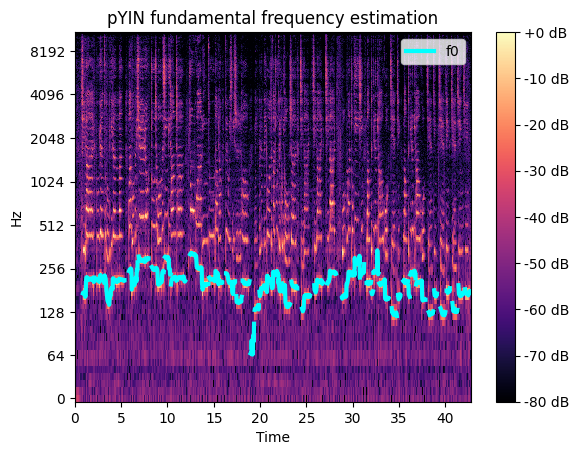

In [14]:
# 测试calAudioFreq
y, sr = librosa.load(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\audio\cst.mp3")
freq_list, times_list = calAudioFreq(reduced_noise=y,sr=sr)
# 画图
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times_list, freq_list, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [37]:
freq_list, times_list

([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  173.52918104210445,
  175.5454930018647,
  172.52972650401387,
  172.52972650401387,
  173.52918104210445,
  173.52918104210445,
  174.53442536143424,
  174.53442536143424,
  172.52972650401387,
  169.56576906952336,
  165.6928815515041,
  163.7897364863335,
  164.73856077731807,
  168.58914210463126,
  199.33268480704808,
  214.87708272009507,
  222.45470667747657,
  223.74337368352585,
  223.74337368352585,
  223.74337368352585,
  222.45470667747657,
  219.8995964441766,
  218.63306796596578,
  217.37383415501247,
  216.12185299712482,
  216.12185299712482,
  216.12185299712482,
  216.12185299712482,
  214.87708272009507,
  216.12185299712482,
  217.37383415501247,
  218.63306796596578,
  218.63306796596578,
  218.633067

In [22]:
# 测试getPerWordFeat
pwf_dict = getPerWordFeat(eigen_dict=eigen_dict,freq_list=freq_list,times_list=times_list)
pwf_dict

{'eigen_list': [{'word': '起',
   'eigen': {'start_time': 0.78,
    'end_time': 1.18,
    'freq': 173.529,
    'times': 0.4}},
  {'word': '来',
   'eigen': {'start_time': 1.18,
    'end_time': 2.26,
    'freq': 217.374,
    'times': 1.08}},
  {'word': '不',
   'eigen': {'start_time': 2.26,
    'end_time': 2.62,
    'freq': 214.877,
    'times': 0.36}},
  {'word': '愿',
   'eigen': {'start_time': 2.62,
    'end_time': 3.14,
    'freq': 219.9,
    'times': 0.52}},
  {'word': '做',
   'eigen': {'start_time': 3.14,
    'end_time': 3.42,
    'freq': 222.455,
    'times': 0.28}},
  {'word': '努',
   'eigen': {'start_time': 3.42,
    'end_time': 3.68,
    'freq': 152.821,
    'times': 0.26}},
  {'word': '力',
   'eigen': {'start_time': 3.68,
    'end_time': 3.86,
    'freq': 164.264,
    'times': 0.18}},
  {'word': '的',
   'eigen': {'start_time': 3.86,
    'end_time': 4.06,
    'freq': 185.984,
    'times': 0.2}},
  {'word': '人',
   'eigen': {'start_time': 4.06,
    'end_time': 4.58,
    'freq': 213

In [23]:
# 测试getSheetMusicFeatDict
notation_feat_dict = getSheetMusicFeatDict()
notation_feat_dict

{'A': {'bpm': 120,
  'key_signature': 'G',
  'time_signature': [2, 4],
  'eigen_list': [{'word': '起', 'eigen': {'note': [329.63], 'time': [0.25]}},
   {'word': '来', 'eigen': {'note': [440.0], 'time': [0.75]}},
   {'word': '不', 'eigen': {'note': [440.0], 'time': [0.25]}},
   {'word': '愿', 'eigen': {'note': [440.0], 'time': [0.375]}},
   {'word': '做', 'eigen': {'note': [440.0], 'time': [0.125]}},
   {'word': '奴', 'eigen': {'note': [329.63], 'time': [0.25]}},
   {'word': '隶', 'eigen': {'note': [370.495], 'time': [0.125]}},
   {'word': '的', 'eigen': {'note': [415.805], 'time': [0.125]}},
   {'word': '人', 'eigen': {'note': [440.0], 'time': [0.5]}},
   {'word': '们', 'eigen': {'note': [440.0], 'time': [0.5]}},
   {'word': '把', 'eigen': {'note': [554.37], 'time': [0.25]}},
   {'word': '我', 'eigen': {'note': [440.0], 'time': [0.25]}},
   {'word': '们', 'eigen': {'note': [494.88], 'time': [0.125]}},
   {'word': '的', 'eigen': {'note': [554.37], 'time': [0.125]}},
   {'word': '血', 'eigen': {'note':

In [32]:
dtw_rs_dict = cal_dtw_freq_and_tempo(notation_feat_dict, pwf_dict)
dtw_rs_dict

{'A': {'freq_dist_normalized': 52.37779803945911,
  'tempo_dist_normalized': 46.78291644655259},
 'A/2': {'freq_dist_normalized': 52.37779803945911,
  'tempo_dist_normalized': 46.78291644655259},
 'A#': {'freq_dist_normalized': 52.41291076186228,
  'tempo_dist_normalized': 46.78291644655259},
 'A#/2': {'freq_dist_normalized': 52.41291076186228,
  'tempo_dist_normalized': 46.78291644655259},
 'B': {'freq_dist_normalized': 52.37999533979377,
  'tempo_dist_normalized': 46.78291644655259},
 'B/2': {'freq_dist_normalized': 52.37999533979377,
  'tempo_dist_normalized': 46.78291644655259},
 'C': {'freq_dist_normalized': 52.549915426853026,
  'tempo_dist_normalized': 46.78291644655259},
 'C/2': {'freq_dist_normalized': 52.549915426853026,
  'tempo_dist_normalized': 46.78291644655259},
 'C#': {'freq_dist_normalized': 52.41537983074971,
  'tempo_dist_normalized': 46.78291644655259},
 'C#/2': {'freq_dist_normalized': 52.41537983074971,
  'tempo_dist_normalized': 46.78291644655259},
 'D': {'freq_d

In [28]:
notation_feat_dict["E/2"]

{'bpm': 120,
 'key_signature': 'G',
 'time_signature': [2, 4],
 'eigen_list': [{'word': '起', 'eigen': {'note': [123.72], 'time': [0.25]}},
  {'word': '来', 'eigen': {'note': [165.315], 'time': [0.75]}},
  {'word': '不', 'eigen': {'note': [165.315], 'time': [0.25]}},
  {'word': '愿', 'eigen': {'note': [165.315], 'time': [0.375]}},
  {'word': '做', 'eigen': {'note': [165.315], 'time': [0.125]}},
  {'word': '奴', 'eigen': {'note': [123.72], 'time': [0.25]}},
  {'word': '隶', 'eigen': {'note': [138.5925], 'time': [0.125]}},
  {'word': '的', 'eigen': {'note': [155.5625], 'time': [0.125]}},
  {'word': '人', 'eigen': {'note': [165.315], 'time': [0.5]}},
  {'word': '们', 'eigen': {'note': [165.315], 'time': [0.5]}},
  {'word': '把', 'eigen': {'note': [207.65], 'time': [0.25]}},
  {'word': '我', 'eigen': {'note': [165.315], 'time': [0.25]}},
  {'word': '们', 'eigen': {'note': [185.495], 'time': [0.125]}},
  {'word': '的', 'eigen': {'note': [207.65], 'time': [0.125]}},
  {'word': '血', 'eigen': {'note': [247.